## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
import numpy as np


class Module(object):
    """
    Basically, you can think of a module as of a something (black box) 
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`: 
        
        output = module.forward(input)
    
    The module should be able to perform a backward pass: to differentiate the `forward` function. 
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule. 
    
        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True
    
    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.
        
        This includes 
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput
    

    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.
        
        Make sure to both store the data in `output` field and return it. 
        """
        
        # The easiest case:
            
        # self.output = input 
        # return self.output
        
        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input. 
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.
        
        The shape of `gradInput` is always the same as the shape of `input`.
        
        Make sure to both store the gradients in `gradInput` field and return it.
        """
        
        # The easiest case:
        
        # self.gradInput = gradOutput 
        # return self.gradInput
        
        pass   
    
    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass
    
    def zeroGradParameters(self): 
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass
        
    def getParameters(self):
        """
        Returns a list with its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
        
    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
    
    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True
    
    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False
    
    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Module"


class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially. 
         
         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`. 
    """
    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:
        
            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})   
            
            
        Just write a little loop. 
        """
        
        self.output = input
        for module in self.modules:
            self.output = module.forward(self.output)
        
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:
            
            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)   
            gradInput = module[0].backward(input, g_1)   
             
             
        !!!
                
        To ech module you need to provide the input, module saw while forward pass, 
        it is used while computing gradients. 
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass) 
        and NOT `input` to this Sequential module. 
        
        !!!
        
        """
        
        for i in range(len(self.modules) - 1, 0, -1):
            gradOutput = self.modules[i].backward(self.modules[i - 1].output, gradOutput)

        self.gradInput = self.modules[0].backward(input, gradOutput)
        
        return self.gradInput
      

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)
    
    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()


class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 

    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        self.output = np.matmul(input, self.W.T) + self.b
        return self.output


    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.matmul(gradOutput, self.W)
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        # input(batch_size, n_in), gradOutput(batch_size, n_out), gradW(n_in, n_out)
        self.gradW += np.matmul(gradOutput.T, input) # == input.T @ gradOutput
        self.gradb += gradOutput.sum(axis=0) # gradOutput(batch_size, n_out), gradb(n_out)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q


class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        self.output = np.exp(self.output)
        self.output = self.output / np.sum(self.output, axis=1, keepdims=True)

        return self.output
    
    def updateGradInput(self, input, gradOutput):
        t1 = np.einsum("bi,bj->bij", self.output, self.output)
        diag = np.eye(input.shape[1])
        t2 = np.einsum("bi,ij->bij", self.output, diag)
        grad = t2 - t1
        self.gradInput = np.einsum("bi,bij->bj", gradOutput, grad)
        
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"


class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        self.output -= np.log(np.sum(np.exp(self.output), axis=1, keepdims=True))

        return self.output
    
    def updateGradInput(self, input, gradOutput):
        t1 = np.einsum('bi,bj->bij', np.exp(self.output), np.ones(self.output.shape))
        diag1 = np.eye(self.output.shape[0], self.output.shape[1])
        diag2 = np.eye(self.output.shape[1])
        t2 = np.einsum('bi,ij->bij', diag1, diag2)
        grad = t2 - t1
        self.gradInput = np.einsum('bij,bi->bj', grad, gradOutput)

        return self.gradInput
    
    def __repr__(self):
        return "LogSoftMax"


class BatchNormalization(Module):
    EPS = 1e-3
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None 
        self.moving_variance = None
        
    def updateOutput(self, input):
        if self.training:
            batch_mean = input.mean(axis=0)
            batch_variance = input.var(axis=0)
            
            self.moving_mean = self.moving_mean * self.alpha + batch_mean * (1 - self.alpha)
            self.moving_variance = self.moving_variance * self.alpha + batch_variance * (1 - self.alpha)

            self.output = (input - batch_mean) / np.sqrt(batch_variance + self.EPS)
        else:
            self.output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)

        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # since math expectation and variance both are functions w.r.t x, we need to diff it as functions
        input_mu = input.mean(axis=0)
        input_var = input.var(axis=0)

        n_in = input.shape[0]
        t = 1. / np.sqrt(input_var + self.EPS)

        self.gradInput = (t / n_in) * (
            n_in * gradOutput - np.sum(gradOutput, axis=0) -
            t ** 2 * (input - input_mu) * np.sum(gradOutput * (input - input_mu), axis=0)
        )

        return self.gradInput
    
    def __repr__(self):
        return "BatchNormalization"


class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)
        
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output
        
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)
    
    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)
        
    def getParameters(self):
        return [self.gamma, self.beta]
    
    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]
    
    def __repr__(self):
        return "ChannelwiseScaling"


class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        
        self.p = p
        self.mask = None
        
    def updateOutput(self, input):
        self.output = input.copy()

        if self.training:
            self.mask = np.random.binomial(1, 1 - self.p, size=self.output.shape) / (1 - self.p)
            self.output *= self.mask

        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.mask
        return self.gradInput
        
    def __repr__(self):
        return "Dropout"


class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.where(input > 0, gradOutput, 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"


class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, input):
        self.output = np.maximum(input, input * self.slope)
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.where(input > 0, gradOutput, gradOutput * self.slope)
        return self.gradInput

    def __repr__(self):
        return "LeakyReLU"


class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()
        
        self.alpha = alpha

    def updateOutput(self, input):
        self.output = np.where(input > 0, input, (np.exp(input) - 1) * self.alpha)
        return  self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.where(input > 0, gradOutput, self.alpha * np.exp(input) * gradOutput)
        return self.gradInput
    
    def __repr__(self):
        return "ELU"


class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.log(np.exp(input) + 1)
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput / (1 + np.exp(-input)) 
        return self.gradInput
    
    def __repr__(self):
        return "SoftPlus"


class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function 
            associated to the criterion and return the result.
            
            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result. 

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput   

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Criterion"


class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def updateOutput(self, input, target):   
        self.output = np.sum(np.power(input - target,2)) / input.shape[0]
        return self.output 
 
    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"


class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, input, target):         
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        self.output = - np.sum(target * np.log(input_clamp)) / input_clamp.shape[0]

        return self.output

    def updateGradInput(self, input, target):        
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        self.gradInput = - (target / input_clamp) / input_clamp.shape[0]

        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"


class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, input, target): 
        self.output = - np.sum(input * target) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        self.gradInput = - target / input.shape[0]
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"


def sgd_momentum(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            old_grad = state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))
            
            np.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad, out=old_grad)
            
            current_var -= old_grad
            var_index += 1


def adam_optimizer(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('m', {})  # first moment vars
    state.setdefault('v', {})  # second moment vars
    state.setdefault('t', 0)   # timestamp
    state['t'] += 1
    for k in ['learning_rate', 'beta1', 'beta2', 'epsilon']:
        assert k in config, config.keys()
    
    var_index = 0 
    lr_t = config['learning_rate'] * np.sqrt(1 - config['beta2']**state['t']) / (1 - config['beta1']**state['t'])
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            var_first_moment = state['m'].setdefault(var_index, np.zeros_like(current_grad))
            var_second_moment = state['v'].setdefault(var_index, np.zeros_like(current_grad))
            
            # <YOUR CODE> #######################################
            # update `current_var_first_moment`, `var_second_moment` and `current_var` values
            #np.add(... , out=var_first_moment)
            #np.add(... , out=var_second_moment)
            #current_var -= ...
            
            # small checks that you've updated the state; use np.add for rewriting np.arrays values
            assert var_first_moment is state['m'].get(var_index)
            assert var_second_moment is state['v'].get(var_index)
            var_index += 1


class Flatten(Module):
    def __init__(self):
         super(Flatten, self).__init__()
    
    def updateOutput(self, input):
        self.output = input.reshape(len(input), -1)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(input.shape)
        return self.gradInput
    
    def __repr__(self):
        return "Flatten"

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

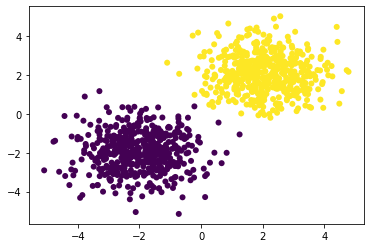

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 8))
net.add(ReLU())
net.add(Linear(8, 2))
net.add(SoftMax())
criterion = ClassNLLCriterionUnstable()

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 8
ReLU
Linear 8 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

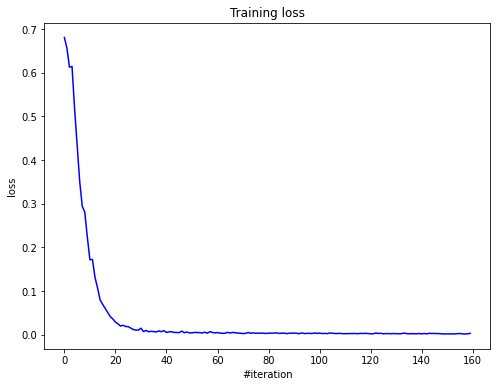

Current loss: 0.003115


In [7]:
loss_history = []

for i in range(n_epoch):
    net.train()
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
y_train_ohe = onehot_encoder.fit_transform(y_train[:, None])
y_val_ohe = onehot_encoder.transform(y_val[:, None])
y_test_ohe = onehot_encoder.transform(y_test[:, None])

In [28]:
from sklearn.metrics import accuracy_score
from collections import defaultdict


def get_simple_net(input_shape=28*28, num_classes=10, activation: Module = ReLU(), use_batch_norm: bool = False):
    model = Sequential()
    model.add(Flatten())

    model.add(Linear(input_shape, 128))
    if use_batch_norm:
        model.add(BatchNormalization())
        model.add(ChannelwiseScaling())
    model.add(activation)

    model.add(Linear(128, num_classes))
    model.add(LogSoftMax())

    return model


def train(
    model: Module,
    criterion: Criterion,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray = None,
    y_valid: np.ndarray = None,
    n_epoch: int = 20,
    batch_size: int = 128,
    learning_rate: float = 1e-1,
    momentum: float = 0.9
):
    loss_history = []
    
    optimizer_config = {'learning_rate' : learning_rate, 'momentum': momentum}
    optimizer_state = {}

    for i in range(n_epoch):
        model.train()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            model.zeroGradParameters()

            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)

            # Update weights
            sgd_momentum(model.getParameters(), 
                         model.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
        
            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()
    
    return model, loss_history

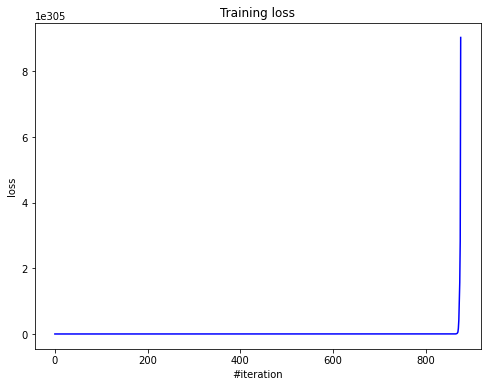

KeyboardInterrupt: 

In [29]:
params = {
    "relu": [ReLU(), False],
    "relu_bn": [ReLU(), True],
    "elu": [ELU(), False],
    "elu_bn": [ELU(), True],
    "leaky_relu": [LeakyReLU(), False],
    "leaky_relu_bn": [LeakyReLU(), True],
    "softplus": [SoftPlus(), False],
    "softplus_bn": [SoftPlus(), True],
}

criterion = ClassNLLCriterion()

history = dict()
for model_name, (activation, use_batch_norm) in params.items():
    model = get_simple_net(
        input_shape=28*28, num_classes=10, activation=activation, use_batch_norm=use_batch_norm
    )
    model, history[model_name] = train(
        model, criterion, X_train, y_train_ohe.toarray(), X_val, y_val_ohe.toarray(), n_epoch=20, batch_size=128
    )

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [ ]:
# Your code goes here. ################################################

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# Your code goes here. ################################################

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [79]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


def get_pytorch_net(
    device,
    input_shape=28*28,
    num_classes=10,
    activation: nn.Module = nn.ReLU(),
    use_batch_norm: bool = False
):
    layers = []
    layers.append(nn.Flatten())
    layers.append(nn.Linear(input_shape, 128))
    
    if use_batch_norm:
        layers.append(nn.BatchNorm1d(128))

    layers.append(activation)
    layers.append(nn.Linear(128, num_classes))
    
    model = nn.Sequential(*layers).to(device)

    return model


def validate_pytorch(
    model,
    criterion,
    X_valid: np.ndarray,
    y_valid: np.ndarray,
    batch_size: int,
):
    with torch.no_grad():
        batch_loss_valid = []
        batch_accuracy_valid = []

        for images, target in get_batches((X_valid, y_valid), batch_size):
            images = images.cuda(device, non_blocking=True)
            target = target.cuda(device, non_blocking=True)
            output = model (images)

            loss = criterion(output, target)
            batch_loss_valid.append(loss.item())

            accuracy = (output.argmax(axis=1) == target).cpu().numpy().mean()
            batch_accuracy_valid.append(accuracy)

        valid_loss = sum(batch_loss_valid) / len(batch_loss_valid)
        valid_accuracy = sum(batch_accuracy_valid) / len(batch_accuracy_valid)

    return valid_loss, valid_accuracy


def train_pytorch(
    model,
    criterion,
    optimizer,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_valid: np.ndarray = None,
    y_valid: np.ndarray = None,
    num_epochs: int = 20,
    batch_size: int = 128,
):    
    history = defaultdict(list)

    for epoch in range(num_epochs):
        model.train()
        loss_epoch = []
        accuracy_epoch = []

        for images, target in get_batches((X_train, y_train), batch_size):
            images = images.cuda(device, non_blocking=True)
            target = target.cuda(device, non_blocking=True)
            output = model(images)

            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        
        train_loss, train_accuracy = validate_pytorch(model, criterion, X_train, y_train, batch_size)
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        
        if X_valid is not None and y_valid is not None:
            valid_loss, valid_accuracy = validate_pytorch(model, criterion, X_valid, y_valid, batch_size)
            history["valid_loss"].append(valid_loss)
            history["valid_accuracy"].append(valid_accuracy)

    return model, history


def plot_training_history(history, title, ax1, ax2):
    best_epoch = np.argmax(history["valid_accuracy"])
    print(f'Best epoch: {best_epoch}, valid_accuracy = {history["valid_accuracy"][best_epoch]}')

    ax1.plot(history["train_loss"])
    if "valid_loss" in history:
        ax1.plot(history["valid_loss"])
    ax1.axvline(x=best_epoch, color="r", linestyle="--")
    ax1.set_title(f"{title} activation, Loss")
    ax1.legend(["train", "valid"])
    
    ax2.plot(history["train_accuracy"])
    if "valid_accuracy" in history:
        ax2.plot(history["valid_accuracy"])
    ax2.axvline(x=best_epoch, color="r", linestyle="--")
    ax2.set_title(f"{title} activation, Accuracy")
    ax2.legend(["train", "valid"])

In [70]:
params = {
    "relu": [nn.ReLU(), False],
    "relu_bn": [nn.ReLU(), True],
    "elu": [nn.ELU(), False],
    "elu_bn": [nn.ELU(), True],
    "leaky_relu": [nn.LeakyReLU(), False],
    "leaky_relu_bn": [nn.LeakyReLU(), True],
    "softplus": [nn.Softplus(), False],
    "softplus_bn": [nn.Softplus(), True],
}

history = dict()
criterion = nn.CrossEntropyLoss()

for model_name, (activation, use_batch_norm) in params.items():
    model = get_pytorch_net(
        device, input_shape=28*28, num_classes=10, activation=activation, use_batch_norm=use_batch_norm
    )
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.75)
    
    history[model_name] = train_pytorch(
        model,
        criterion,
        optimizer,
        torch.tensor(X_train),
        torch.tensor(y_train, dtype=torch.long),
        torch.tensor(X_val),
        torch.tensor(y_val, dtype=torch.long),
        num_epochs=50, batch_size=128
    )

Best epoch: 48, valid_accuracy = 0.9634098101265823
Best epoch: 39, valid_accuracy = 0.9776503164556962
Best epoch: 48, valid_accuracy = 0.9567840189873418
Best epoch: 49, valid_accuracy = 0.9729034810126582
Best epoch: 49, valid_accuracy = 0.9664754746835443
Best epoch: 48, valid_accuracy = 0.974881329113924
Best epoch: 49, valid_accuracy = 0.9457080696202531
Best epoch: 41, valid_accuracy = 0.9719145569620253


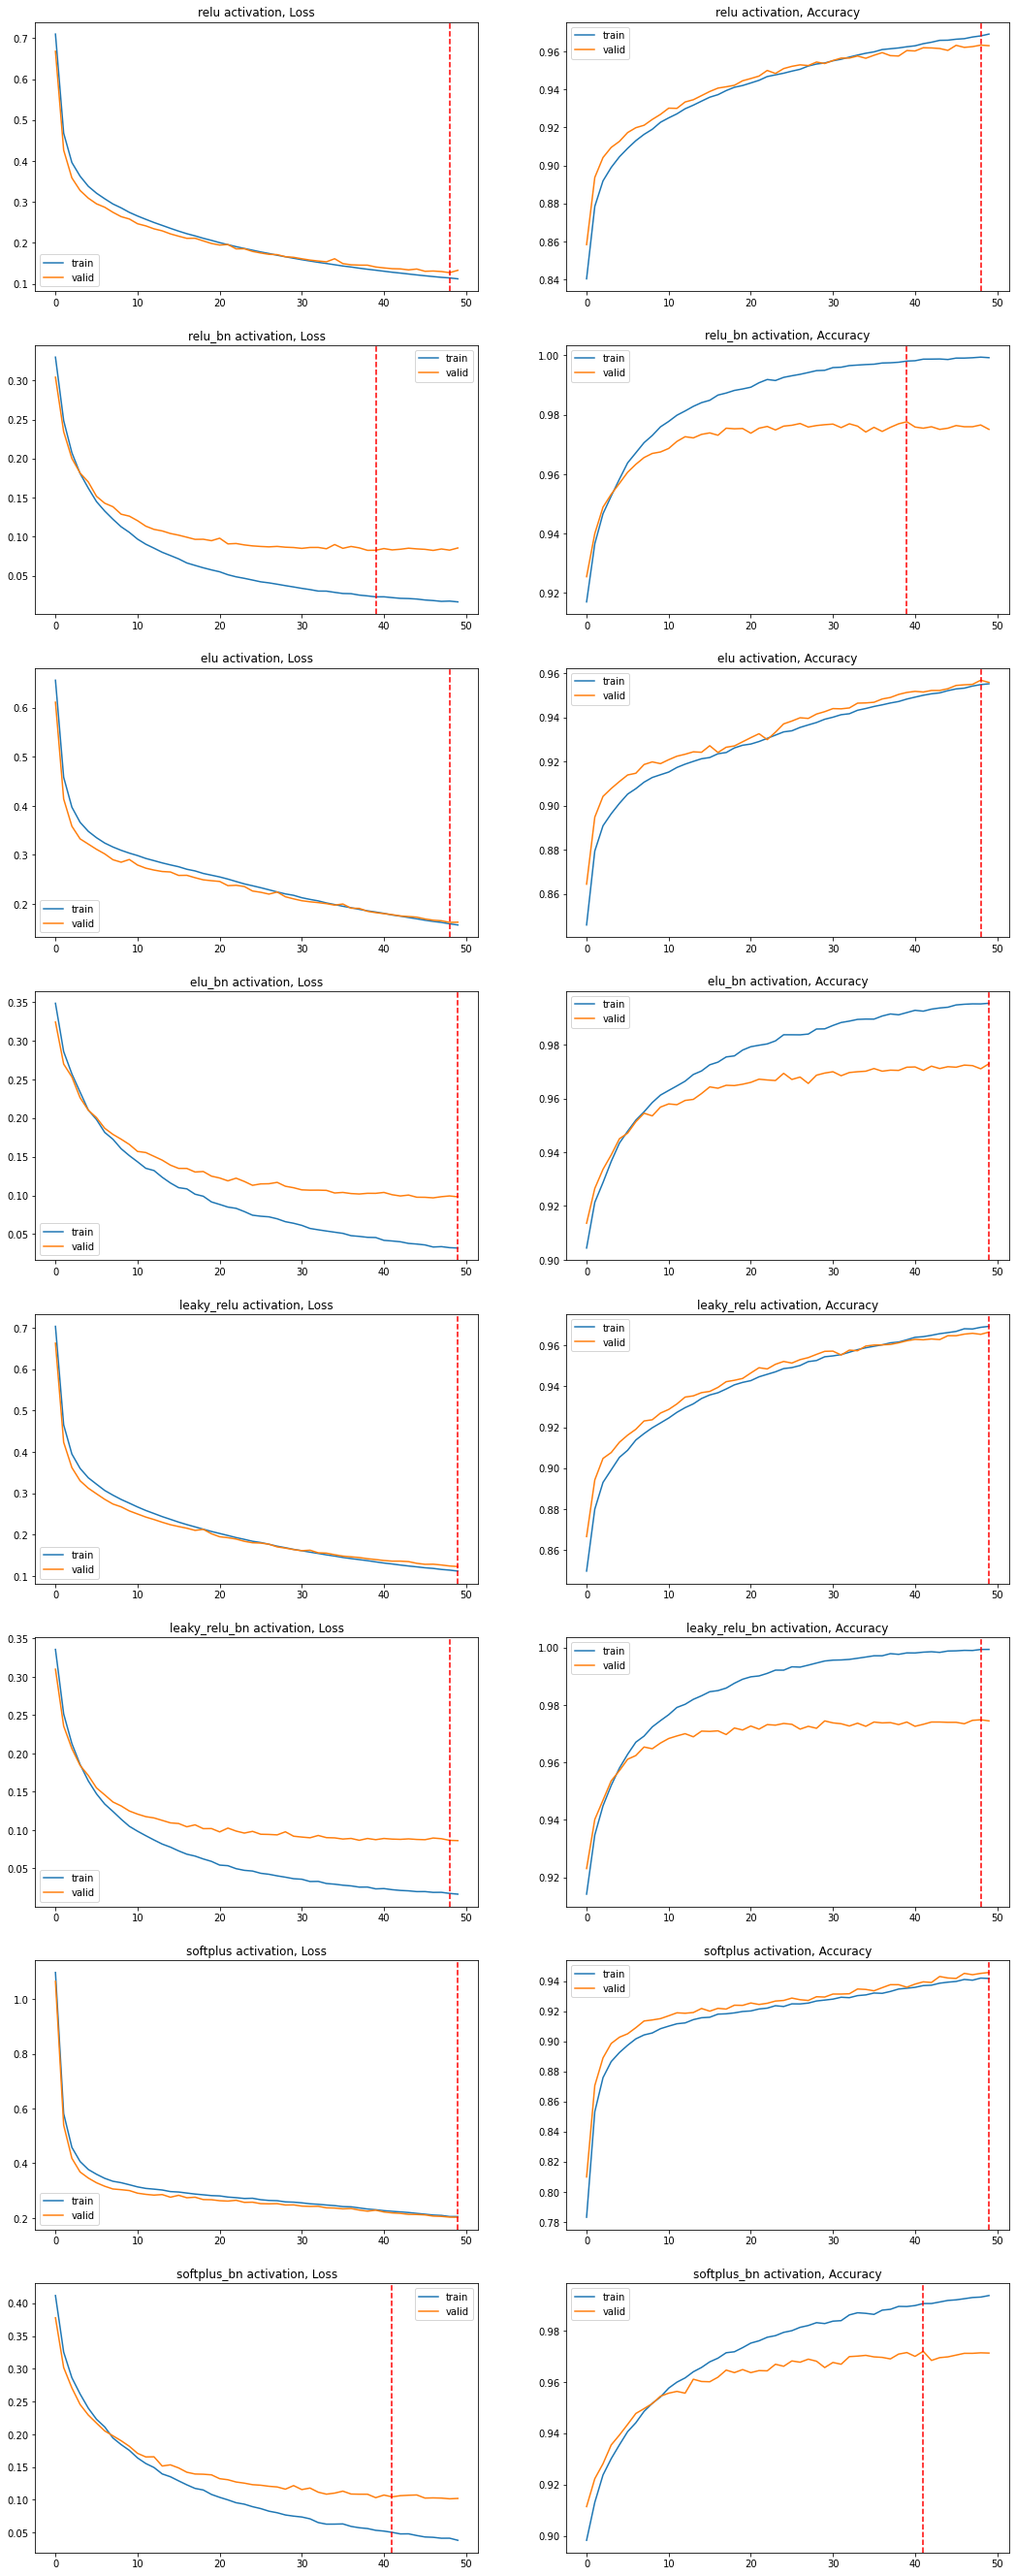

In [80]:
fig, ax = plt.subplots(8, 2, figsize=(18, 48))
for (ax1, ax2), (title, model_history) in zip(ax, history.items()):
    plot_training_history(model_history[1], title, ax1, ax2)